In [1]:
from diffusers import DiffusionPipeline, StableDiffusionPipeline
import torch

pipe: StableDiffusionPipeline = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16,
    requires_safety_checker=False,
    feature_extractor=None
).to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/data/gunsbrother/anaconda3/envs/vq2d/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
prompt = "A plug laid on a table"
num_images = 1
gen = torch.Generator(device='cuda').manual_seed(42)
images = pipe(
    prompt,
    negative_prompt="ugly, deformed, disfigured, poor details, bad anatomy",
    num_images_per_prompt=num_images,
    generator=gen
).images

  0%|          | 0/50 [00:00<?, ?it/s]

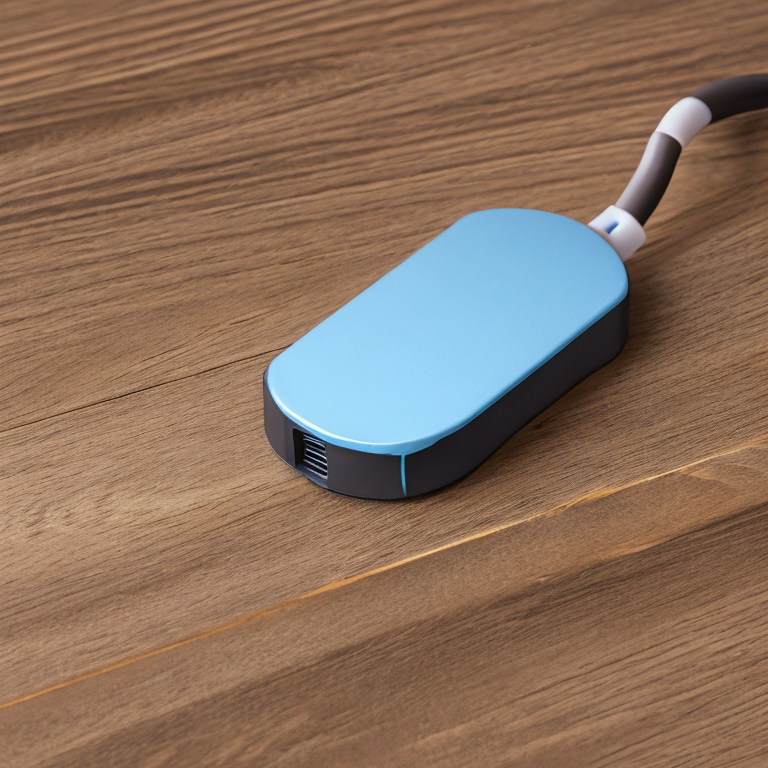

In [3]:
images[0]

In [4]:
import json
from PIL import Image
from einops import rearrange
import numpy as np
from diffusers.utils import make_image_grid
from diffusers.models.attention_processor import AttnProcessor2_0

pipe.unet.set_attn_processor(AttnProcessor2_0())
pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)
torch.set_float32_matmul_precision('high')

In [5]:
all_anns = {
    'train': json.load(open('data/vq_v2_train_anno.json')),
    'val': json.load(open('data/vq_v2_val_anno.json'))
}
len(all_anns['train']), len(all_anns['val'])

(13607, 4504)

In [6]:
object_titles = {
    split: {ann['object_title'] for ann in anns}
    for split, anns in all_anns.items()
}
len(object_titles['train'])

2853

In [7]:
sample_obj = list(object_titles['train'])[1238]
sample_obj

'melon fruit'

In [8]:
sample_obj = 'a jug'
prompt = f"{sample_obj}"
num_images = 6
gen = torch.Generator(device='cuda').manual_seed(42)
images = pipe(
    prompt,
    negative_prompt="ugly, deformed, disfigured, poor details, bad anatomy",
    num_images_per_prompt=num_images,
    generator=gen
).images

  0%|          | 0/50 [00:00<?, ?it/s]

W1007 02:33:10.933000 139758475421504 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] q1 is not in var_ranges, defaulting to unknown range.
W1007 02:33:11.002000 139758475421504 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] z1 is not in var_ranges, defaulting to unknown range.
W1007 02:33:11.732000 139758475421504 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] q1 is not in var_ranges, defaulting to unknown range.
W1007 02:33:11.799000 139758475421504 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] z1 is not in var_ranges, defaulting to unknown range.
W1007 02:33:12.510000 139758475421504 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] q1 is not in var_ranges, defaulting to unknown range.
W1007 02:33:12.576000 139758475421504 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] z1 is not in var_ranges, defaulting to unknown range.
W1007 02:33:13.407000 139758475421504 torch/fx/experimental/symbolic_shapes.py:4449] [0/0] q1 is not in var_ranges, defaulting to 

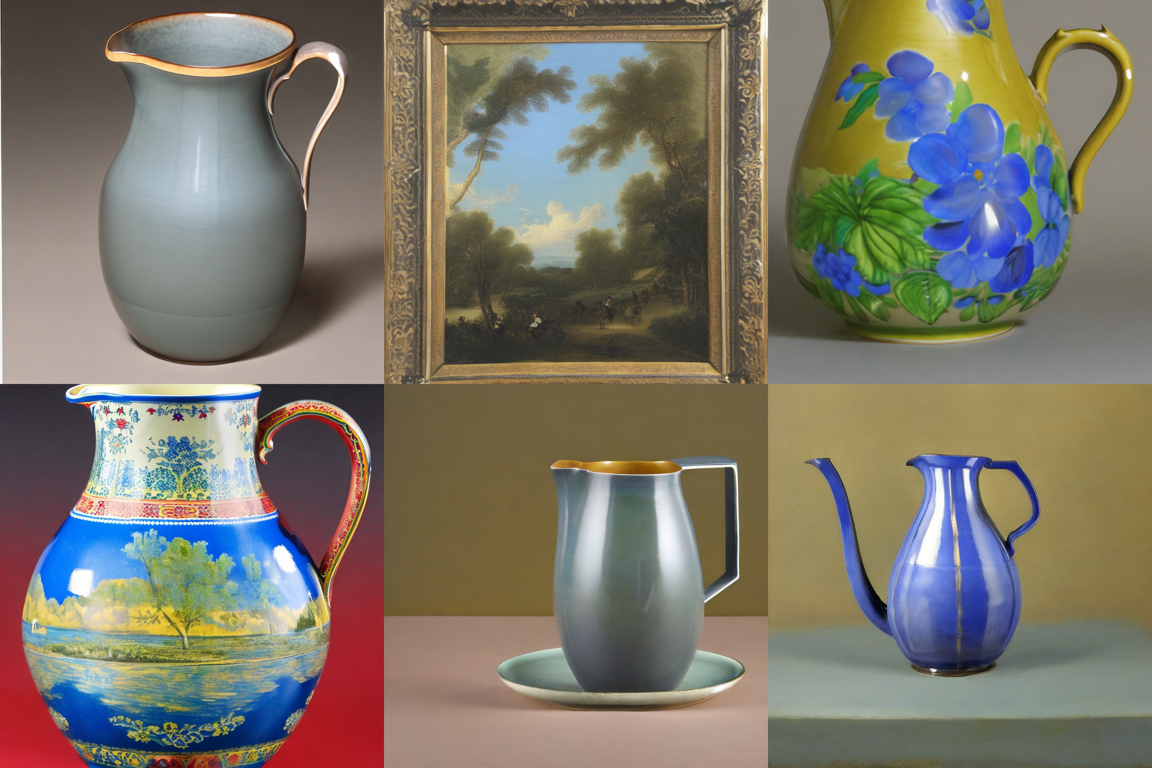

In [9]:
images_collage = np.array([np.array(img) for img in images])
images_collage = rearrange(images_collage, '(bh bw) h w c -> (bh h) (bw w) c', bh=2)
images_collage = Image.fromarray(images_collage)
images_collage = images_collage.resize((images_collage.width // 2, images_collage.height // 2))
images_collage